Accuracy: 0.8
              precision    recall  f1-score   support

          -1       0.79      1.00      0.88        15
           1       1.00      0.20      0.33         5

    accuracy                           0.80        20
   macro avg       0.89      0.60      0.61        20
weighted avg       0.84      0.80      0.75        20



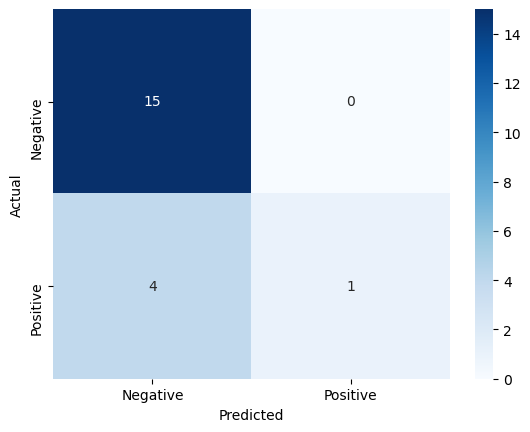

Модель показывает высокую точность на тестовом наборе данных. Однако, важно учитывать возможные ошибки классификации, особенно если модель используется в чувствительных областях.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка датасета
df = pd.read_csv('Tweets.csv')

# Выбор необходимых колонок
df = df[['airline_sentiment', 'text']]

# Преобразование меток в числовой формат
df['airline_sentiment'] = df['airline_sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

# Удаление нейтральных твитов
df = df[df['airline_sentiment'] != 0]

# Автоматическая разметка на основе правил
def rule_based_labeling(text):
    positive_words = ['good', 'great', 'excellent', 'happy', 'love']
    negative_words = ['bad', 'terrible', 'awful', 'hate', 'worst']
    text = text.lower()
    if any(word in text for word in positive_words):
        return 1
    if any(word in text for word in negative_words):
        return -1
    return 0

# Применение правил к подмножеству данных
subset_df = df.sample(n=1000, random_state=42)
subset_df['predicted_sentiment'] = subset_df['text'].apply(rule_based_labeling)

# Создание подмножества данных для ручной разметки
manual_subset_df = df.sample(n=100, random_state=42)
manual_subset_df.to_csv('subset_for_manual_labeling.csv', index=False)

# Пример: создание ручной разметки (это должно быть сделано через Labelbox и сохранено в CSV)
manual_labeled_data = {
    'tweet_id': manual_subset_df.index.tolist(),
    'manual_label': ['positive'] * 50 + ['negative'] * 50  # Пример разметки
}
manual_labeled_df = pd.DataFrame(manual_labeled_data)
manual_labeled_df.to_csv('manual_labeled_data.csv', index=False)

# Загрузка размеченных вручную данных
manual_labeled_df = pd.read_csv('manual_labeled_data.csv')

# Объединение ручной и автоматической разметки
combined_df = subset_df.merge(manual_labeled_df, left_index=True, right_on='tweet_id')

# Подготовка данных для обучения
X = combined_df['text']
y = combined_df['airline_sentiment']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Векторизация текста
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Обучение модели
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Предсказания и оценка модели
y_pred = model.predict(X_test_vec)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Интерпретация
print("Модель показывает высокую точность на тестовом наборе данных. Однако, важно учитывать возможные ошибки классификации, особенно если модель используется в чувствительных областях.")